# ML-8. Ансамблирование. Бэггинг, стекинг, бустинг

In [2]:
# Импортируем библиотеки
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

**Загрузка данных**

In [3]:
# Загрузим датасет из библиотеки
data = load_diabetes(as_frame=True)
# Создаем матрицу наблюдений
X = data['frame'].drop('target', axis=1)
# Создаем вектор правильных ответов
y = data['target']
 
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


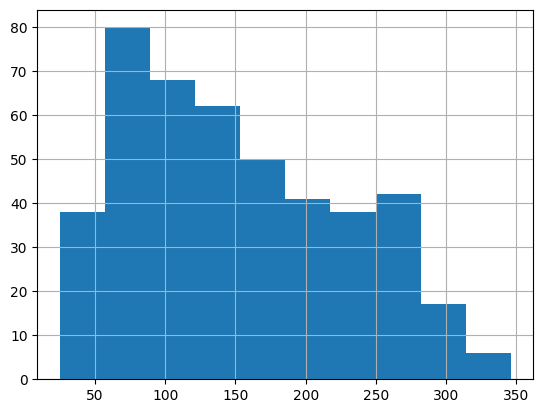

In [103]:
# Посмотрим на распределение целевого признака
y.hist();

In [4]:
# Разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Посмотрим на размерности выборок
print(f'Размерность обучающей выборки {X_train.shape}')
print(f'Размерность тестовой выборки {X_test.shape}')

Размерность обучающей выборки (296, 10)
Размерность тестовой выборки (146, 10)


## Бэггинг: случайный лес. 


In [105]:
bed_model1=DecisionTreeRegressor(max_depth=1000,random_state=42)
bed_model2=RandomForestRegressor(max_depth=1000,n_estimators=10,random_state=42)

bed_model1.fit(X_train,y_train)
bed_model2.fit(X_train,y_train)

RandomForestRegressor(max_depth=1000, n_estimators=10, random_state=42)

In [106]:
predict_bed_model1=bed_model1.predict(X_test)
predict_bed_model2=bed_model2.predict(X_test)

In [110]:
print('первая модель {:.2f}'.format(mean_squared_error(y_test,predict_bed_model1)))
print('вторая модель {}'.format(np.round(mean_squared_error(y_test,predict_bed_model2)),2))

первая модель 6430.63
вторая модель 3549.0


In [90]:
from sklearn.model_selection import learning_curve 

In [91]:
size,train,test=learning_curve(estimator=bed_model1,
                               scoring='neg_root_mean_squared_error',
                               cv=5,
                               X=X_train,
                               y=y_train)

In [92]:
import matplotlib.pyplot as plt

In [93]:
train=np.mean(train,axis=1)
test=np.mean(test,axis=1)



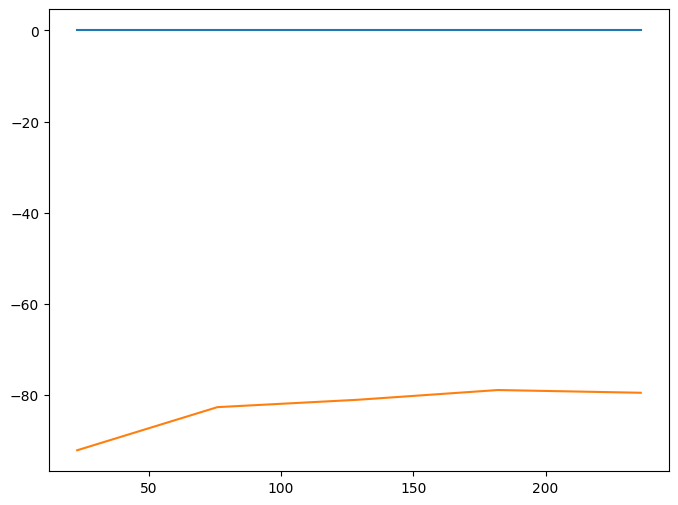

In [94]:
fig,ax=plt.subplots(figsize=(8,6))

ax.plot(size,train)
ax.plot(size,test)

In [72]:
# Создаем модель дерева решений с максимальной глубиной 10 
regr1 = DecisionTreeRegressor(max_depth=10, random_state=42)
# Обучаем модель
regr1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [73]:
# Создаем модель случайного леса из 10 деревьев с максимальной глубиной 10 для каждого дерева 
regr2 = RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)
# Обучаем модель
regr2.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [74]:
# Формируем предсказания каждой из моделей
y_pred1 = regr1.predict(X_test)
y_pred2 = regr2.predict(X_test)
 
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для решающего дерева {round(mean_squared_error(y_test, y_pred1),2)}')
print(f'Качество предсказания по MSE для случайного леса  {round(mean_squared_error(y_test, y_pred2),2)}')

Качество предсказания по MSE для решающего дерева 6132.51
Качество предсказания по MSE для случайного леса  3533.73


 ## Стекинг

In [112]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

In [113]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', RidgeCV()),
    ('dt',  DecisionTreeRegressor(random_state=42))
]

# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)
# Обучаем модель
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', RidgeCV()),
                              ('dt', DecisionTreeRegressor(random_state=42))],
                  final_estimator=RandomForestRegressor(n_estimators=10,
                                                        random_state=42))

In [114]:
# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test)
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для стекинга {round(mean_squared_error(y_test, y_pred_stack), 2)}')

Качество предсказания по MSE для стекинга 3467.74


In [78]:
# Получаем мета-признаки из тренировочных данных
meta_data = reg.transform(X_train)
# Создаем DataFrame
meta_df = pd.DataFrame(
    meta_data, #содержимое таблицы
    columns=['meta_feature1', 'meta_feature2',] #название столбцов
)
meta_df.head()

,meta_feature1,meta_feature2
0,152.477333,154.0
1,202.022338,192.0
2,133.718464,116.0
3,146.698345,81.0
4,169.783292,122.0


In [115]:
from sklearn.linear_model import LinearRegression

In [117]:
estimators=[
    ('lrcv',RidgeCV()),
    ('lr',LinearRegression())
]

model=StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=100,max_depth=10,
                                          random_state=42)
)
model.fit(X_train,y_train)
predict=model.predict(X_test)
mean_squared_error(y_test,predict).round(2)

3534.69

 ## Бустинг
 



### Адаптивный бустинг

In [7]:
from sklearn.ensemble import AdaBoostRegressor

# Создаем объект класса дерева решений
dt = DecisionTreeRegressor(
    max_depth=3, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost
ada = AdaBoostRegressor(
    estimator=dt, #базовая модель
    n_estimators=100, #количество моделей в ансамбле
    random_state=42 #датчик генератора случайных чисел
)
# Обучаем модель
ada.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
ada_pred  = ada.predict(X_test)

# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для AdaBoost {round(mean_squared_error(y_test, ada_pred),2)}')


Качество предсказания по MSE для AdaBoost 3101.68


### Градиентный бустинг (регрессия)

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
     #максимальная глубина дерева
    n_estimators=100, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(X_test)

# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для GradientBoostingRegressor {round(mean_squared_error(y_test, gb_pred),2)}')

Качество предсказания по MSE для GradientBoostingRegressor 3286.02


### Градиентный бустинг (классификация)

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [25]:
df = pd.read_csv('winequality-red.zip', sep = ';')
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [30]:
# Создаем матрицу наблюдений
X = df.drop(['quality'],axis = 1)
# Создаем вектор признаков для бинарной классификации
y = (df['quality'] >5).astype(int)

In [29]:
y.value_counts()

1    855
0    744
Name: quality, dtype: int64

In [32]:
# Разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
# Посмотрим на размерности выборок
print(f' Размерность обучающей выборки {X_train.shape}')
print(f' Размерность тестовой выборки {X_test.shape}')
# Будет выведено:
# Размерность обучающей выборки (1071, 11)
# Размерность тестовой выборки (528, 11)

 Размерность обучающей выборки (1071, 11)
 Размерность тестовой выборки (528, 11)


In [43]:
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    loss='log_loss', #функция потерь
    learning_rate=0.2, #темп обучения
    n_estimators=500, #число деревьев
    max_depth=3, #максимальная глубина дерева
    random_state=42,
    min_samples_leaf=10 #генератор случайных чисел
)

In [44]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, min_samples_leaf=10,
                           n_estimators=500, random_state=42)

In [45]:
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       238
           1       0.81      0.83      0.82       290

    accuracy                           0.80       528
   macro avg       0.79      0.79      0.79       528
weighted avg       0.80      0.80      0.80       528



In [39]:
# Прогнозируем вероятности принадлежности к классам
y_pred_proba = gb.predict_proba(X_test)
print(y_pred_proba)

[[0.64916863 0.35083137]
 [0.80459408 0.19540592]
 [0.66418585 0.33581415]
 ...
 [0.10699995 0.89300005]
 [0.70918506 0.29081494]
 [0.7486765  0.2513235 ]]
